# Surgery pipeline with TRVAE - comparison between zero-, one-shot and full query training

In [1]:
import scib

In [2]:
import os
import timeit
os.chdir('../')
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)

In [3]:
import scanpy as sc
import torch
import scarches as sca
from scarches.dataset.trvae.data_handling import remove_sparsity
import matplotlib.pyplot as plt
import numpy as np
import gdown

/home/icb/aleksandra.topalova/miniconda3/lib/python3.9/site-packages/torch/utils/tensorboard/__init__.py:4: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if not hasattr(tensorboard, "__version__") or LooseVersion(
/home/icb/aleksandra.topalova/miniconda3/lib/python3.9/site-packages/torch/utils/tensorboard/__init__.py:6: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  ) < LooseVersion("1.15"):
Global seed set to 0
/home/icb/aleksandra.topalova/miniconda3/lib/python3.9/site-packages/pytorch_lightning/utilities/warnings.py:53: LightningDeprecationWarning: pytorch_lightning.utilities.warnings.rank_zero_deprecation has been deprecated in v1.6 and will be removed in v1.8. Use the equivalent function from the pytorch_lightning.utilities.rank_zero module instead.
  new_rank_zero_deprecation(
/home/icb/aleksandra.topalova/miniconda3/lib/python3.9/site-packages/pytorch_lightning/utilities/warnings.py:

In [4]:
sc.settings.set_figure_params(dpi=200, frameon=False)
sc.set_figure_params(dpi=200)
sc.set_figure_params(figsize=(4, 4))
torch.set_printoptions(precision=3, sci_mode=False, edgeitems=7)

### Set relevant anndata.obs labels and training length

In [5]:
condition_key = 'study'
cell_type_key = 'cell_type'
target_conditions = ['Kang']

trvae_epochs = 500
alpha_epoch = 200 
surgery_epochs = 500

early_stopping_kwargs = {
    "early_stopping_metric": "val_unweighted_loss",
    "threshold": 0,
    "patience": 20,
    "reduce_lr": True,
    "lr_patience": 13,
    "lr_factor": 0.1,
}

### Download Dataset and split into reference dataset and query dataset

In [6]:
url = 'https://drive.google.com/uc?id=1Rnm-XKEqPLdOq3lpa3ka2aV4bOXVCLP0'
output = 'pbmc_tutorial.h5ad'
gdown.download(url, output, quiet=False)

Downloading...
From: https://drive.google.com/uc?id=1Rnm-XKEqPLdOq3lpa3ka2aV4bOXVCLP0
To: /home/icb/aleksandra.topalova/scarches/notebooks/pbmc_tutorial.h5ad
100%|██████████| 231M/231M [00:02<00:00, 101MB/s]  


'pbmc_tutorial.h5ad'

In [7]:
source_adata = sc.read(output)

/home/icb/aleksandra.topalova/miniconda3/lib/python3.9/site-packages/anndata/_io/h5ad.py:238: OldFormatWarning: Element '/X' was written without encoding metadata.
  d[k] = read_elem(f[k])
/home/icb/aleksandra.topalova/miniconda3/lib/python3.9/site-packages/anndata/_io/h5ad.py:238: OldFormatWarning: Element '/layers' was written without encoding metadata.
  d[k] = read_elem(f[k])
/home/icb/aleksandra.topalova/miniconda3/lib/python3.9/site-packages/anndata/_io/specs/methods.py:92: OldFormatWarning: Element '/layers/counts' was written without encoding metadata.
  return {k: read_elem(v) for k, v in elem.items()}
/home/icb/aleksandra.topalova/miniconda3/lib/python3.9/site-packages/anndata/_io/specs/methods.py:584: OldFormatWarning: Element '/obs/__categories/batch' was written without encoding metadata.
  categories = read_elem(categories_dset)
/home/icb/aleksandra.topalova/miniconda3/lib/python3.9/site-packages/anndata/_io/specs/methods.py:587: OldFormatWarning: Element '/obs/batch' was

In [8]:
source_adata.X = source_adata.layers["counts"].copy()

In [9]:
url = 'https://drive.google.com/uc?id=1136LntaVr92G1MphGeMVcmpE0AqcqM6c'
output = 'reactome.gmt'
gdown.download(url, output, quiet=False)

Downloading...
From: https://drive.google.com/uc?id=1136LntaVr92G1MphGeMVcmpE0AqcqM6c
To: /home/icb/aleksandra.topalova/scarches/notebooks/reactome.gmt
100%|██████████| 331k/331k [00:00<00:00, 9.95MB/s]


'reactome.gmt'

In [10]:
sca.utils.add_annotations(source_adata, 'reactome.gmt', min_genes=12, clean=True)

In [11]:
source_adata._inplace_subset_var(source_adata.varm['I'].sum(1)>0)

In [12]:
source_adata.raw = source_adata
sc.pp.normalize_total(source_adata)
sc.pp.log1p(source_adata)

In [13]:
sc.pp.highly_variable_genes(
    source_adata,
    n_top_genes=2000,
    batch_key="batch",
    subset=True)

In [14]:
select_terms = source_adata.varm['I'].sum(0)>12

In [15]:
source_adata.uns['terms'] = np.array(source_adata.uns['terms'])[select_terms].tolist()

In [16]:
source_adata.varm['I'] = source_adata.varm['I'][:, select_terms]

In [17]:
source_adata._inplace_subset_var(source_adata.varm['I'].sum(1)>0)

In [18]:
source_adata.X = source_adata.layers["counts"].copy()

Query

In [19]:
url = 'https://drive.google.com/uc?id=1t3oMuUfueUz_caLm5jmaEYjBxVNSsfxG'
output = 'kang_tutorial.h5ad'
gdown.download(url, output, quiet=False)

Downloading...
From: https://drive.google.com/uc?id=1t3oMuUfueUz_caLm5jmaEYjBxVNSsfxG
To: /home/icb/aleksandra.topalova/scarches/notebooks/kang_tutorial.h5ad
100%|██████████| 26.8M/26.8M [00:00<00:00, 78.7MB/s]


'kang_tutorial.h5ad'

In [21]:
target_adata = sc.read('kang_tutorial.h5ad')[:, source_adata.var_names].copy()

/home/icb/aleksandra.topalova/miniconda3/lib/python3.9/site-packages/anndata/_io/h5ad.py:238: OldFormatWarning: Element '/X' was written without encoding metadata.
  d[k] = read_elem(f[k])
/home/icb/aleksandra.topalova/miniconda3/lib/python3.9/site-packages/anndata/_io/specs/methods.py:584: OldFormatWarning: Element '/obs/__categories/orig.ident' was written without encoding metadata.
  categories = read_elem(categories_dset)
/home/icb/aleksandra.topalova/miniconda3/lib/python3.9/site-packages/anndata/_io/specs/methods.py:587: OldFormatWarning: Element '/obs/orig.ident' was written without encoding metadata.
  read_elem(dataset), categories, ordered=ordered
/home/icb/aleksandra.topalova/miniconda3/lib/python3.9/site-packages/anndata/_io/specs/methods.py:590: OldFormatWarning: Element '/obs/nCount_RNA' was written without encoding metadata.
  return read_elem(dataset)
/home/icb/aleksandra.topalova/miniconda3/lib/python3.9/site-packages/anndata/_io/specs/methods.py:590: OldFormatWarning:

In [22]:
target_adata.obs['study'] = 'Kang'

In [24]:
target_adata.uns['terms'] = source_adata.uns['terms']

In [25]:
target_adata.obs['ref_or_query'] = 'query'
source_adata.obs['ref_or_query'] = 'ref'

In [26]:
source_conditions = source_adata.obs[condition_key].unique().tolist()

In [27]:
source_adata

AnnData object with n_obs × n_vars = 32484 × 1972
    obs: 'batch', 'chemistry', 'data_type', 'dpt_pseudotime', 'final_annotation', 'mt_frac', 'n_counts', 'n_genes', 'sample_ID', 'size_factors', 'species', 'study', 'tissue', 'cell_type', 'ref_or_query'
    var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'highly_variable_intersection'
    uns: 'terms', 'log1p', 'hvg'
    varm: 'I'
    layers: 'counts'

In [28]:
target_adata

AnnData object with n_obs × n_vars = 13576 × 1972
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'stim', 'seurat_annotations', 'integrated_snn_res.0.5', 'seurat_clusters', 'condition', 'cell_type', 'study', 'ref_or_query'
    uns: 'terms'

Combined

In [29]:
adata = sc.AnnData.concatenate(
    source_adata, target_adata,
    uns_merge='same'
    )

In [30]:
adata.obs.head()

batch chemistry data_type  dpt_pseudotime  \
index                                                                     
AAACCTGCAGCGAACA-1-Oetjen_A-0     0    v2_10X       UMI             NaN   
AAACCTGCATGTCCTC-1-Oetjen_A-0     0    v2_10X       UMI             NaN   
AAACCTGGTCGACTGC-1-Oetjen_A-0     0    v2_10X       UMI             NaN   
AAACCTGGTCGCTTCT-1-Oetjen_A-0     0    v2_10X       UMI             NaN   
AAACCTGTCCCGACTT-1-Oetjen_A-0     0    v2_10X       UMI             NaN   

                              final_annotation   mt_frac  n_counts  n_genes  \
index                                                                         
AAACCTGCAGCGAACA-1-Oetjen_A-0  CD16+ Monocytes  0.047970    6379.0   1862.0   
AAACCTGCATGTCCTC-1-Oetjen_A-0     CD4+ T cells  0.024928    4172.0   1082.0   
AAACCTGGTCGACTGC-1-Oetjen_A-0  CD14+ Monocytes  0.051907    6608.0   1618.0   
AAACCTGGTCGCTTCT-1-Oetjen_A-0  CD14+ Monocytes  0.041716    5034.0   1413.0   
AAACCTGTCCCGACTT-1-Oetjen_A-0        NKT cells  0.043522    3998.0   1127.0   

                              sample_ID  size_factors  ...        cell_type  \
index                                                  ...                    
AAACCTGCAGCGAACA-1-Oetjen_A-0         0      0.957719  ...  CD16+ Monocytes   
AAACCTGCATGTCCTC-1-Oetjen_A-0         0      0.425532  ...     CD4+ T cells   
AAACCTGGTCGACTGC-1-Oetjen_A-0         0      0.773111  ...  CD14+ Monocytes   
AAACCTGGTCGCTTCT-1-Oetjen_A-0         0      0.641188  ...  CD14+ Monocytes   
AAACCTGTCCCGACTT-1-Oetjen_A-0         0      0.452426  ...        NKT cells   

                              ref_or_query orig.ident nCount_RNA nFeature_RNA  \
index                                                                           
AAACCTGCAGCGAACA-1-Oetjen_A-0          ref        NaN        NaN          NaN   
AAACCTGCATGTCCTC-1-Oetjen_A-0          ref        NaN        NaN          NaN   
AAACCTGGTCGACTGC-1-Oetjen_A-0          ref        NaN        NaN          NaN   
AAACCTGGTCGCTTCT-1-Oetjen_A-0          ref        NaN        NaN          NaN   
AAACCTGTCCCGACTT-1-Oetjen_A-0          ref        NaN        NaN          NaN   

                              stim  seurat_annotations  \
index                                                    
AAACCTGCAGCGAACA-1-Oetjen_A-0  NaN                 NaN   
AAACCTGCATGTCCTC-1-Oetjen_A-0  NaN                 NaN   
AAACCTGGTCGACTGC-1-Oetjen_A-0  NaN                 NaN   
AAACCTGGTCGCTTCT-1-Oetjen_A-0  NaN                 NaN   
AAACCTGTCCCGACTT-1-Oetjen_A-0  NaN                 NaN   

                               integrated_snn_res.0.5 seurat_clusters  \
index                                                                   
AAACCTGCAGCGAACA-1-Oetjen_A-0                     NaN             NaN   
AAACCTGCATGTCCTC-1-Oetjen_A-0                     NaN             NaN   
AAACCTGGTCGACTGC-1-Oetjen_A-0                     NaN             NaN   
AAACCTGGTCGCTTCT-1-Oetjen_A-0                     NaN             NaN   
AAACCTGTCCCGACTT-1-Oetjen_A-0                     NaN             NaN   

                              condition  
index                                    
AAACCTGCAGCGAACA-1-Oetjen_A-0       NaN  
AAACCTGCATGTCCTC-1-Oetjen_A-0       NaN  
AAACCTGGTCGACTGC-1-Oetjen_A-0       NaN  
AAACCTGGTCGCTTCT-1-Oetjen_A-0       NaN  
AAACCTGTCCCGACTT-1-Oetjen_A-0       NaN  

[5 rows x 23 columns]

### Create TRVAE model and train it on reference dataset

Create the trVAE model instance with NB loss as default. Insert "recon_loss='mse'," or "recon_loss='zinb'," to change the reconstruction loss.

In [31]:
trvae = sca.models.TRVAE(
    adata=source_adata,
    condition_key=condition_key,
    conditions=source_conditions,
    hidden_layer_sizes=[128, 128],
)


INITIALIZING NEW NETWORK..............
Encoder Architecture:
	Input Layer in, out and cond: 1972 128 4
	Hidden Layer 1 in/out: 128 128
	Mean/Var Layer in/out: 128 10
Decoder Architecture:
	First Layer in, out and cond:  10 128 4
	Hidden Layer 1 in/out: 128 128
	Output Layer in/out:  128 1972 



In [32]:
trvae.train(
    n_epochs=trvae_epochs,
    alpha_epoch_anneal=alpha_epoch,
    early_stopping_kwargs=early_stopping_kwargs,
    weight_decay=0
)

 |██------------------| 13.2%  - val_loss: 901.0449876052 - val_recon_loss: 889.7115079440 - val_kl_loss: 17.7635030746 - val_mmd_loss: 5.56034454930
ADJUSTED LR
 |███-----------------| 17.2%  - val_loss: 897.4080974872 - val_recon_loss: 885.7720313439 - val_kl_loss: 16.1756968498 - val_mmd_loss: 4.7614082923
ADJUSTED LR
 |████----------------| 20.0%  - val_loss: 900.2058997521 - val_recon_loss: 887.6700439453 - val_kl_loss: 15.4657232211 - val_mmd_loss: 4.8803336070
ADJUSTED LR
 |████----------------| 21.4%  - val_loss: 899.8273315430 - val_recon_loss: 886.8582716722 - val_kl_loss: 15.3450489411 - val_mmd_loss: 4.8361938917
Stopping early: no improvement of more than 0 nats in 20 epochs
If the early stopping criterion is too strong, please instantiate it with different parameters in the train method.
Saving best state of network...
Best State was in Epoch 85


### Create anndata file of latent representation and compute UMAP

In [33]:
adata_latent = sc.AnnData(trvae.get_latent())
adata_latent.obs['cell_type'] = source_adata.obs[cell_type_key].tolist()
adata_latent.obs[condition_key] = source_adata.obs[condition_key].tolist()

/home/icb/aleksandra.topalova/miniconda3/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:163: PendingDeprecationWarning: The get_cmap function will be deprecated in a future version. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = copy(get_cmap(cmap))


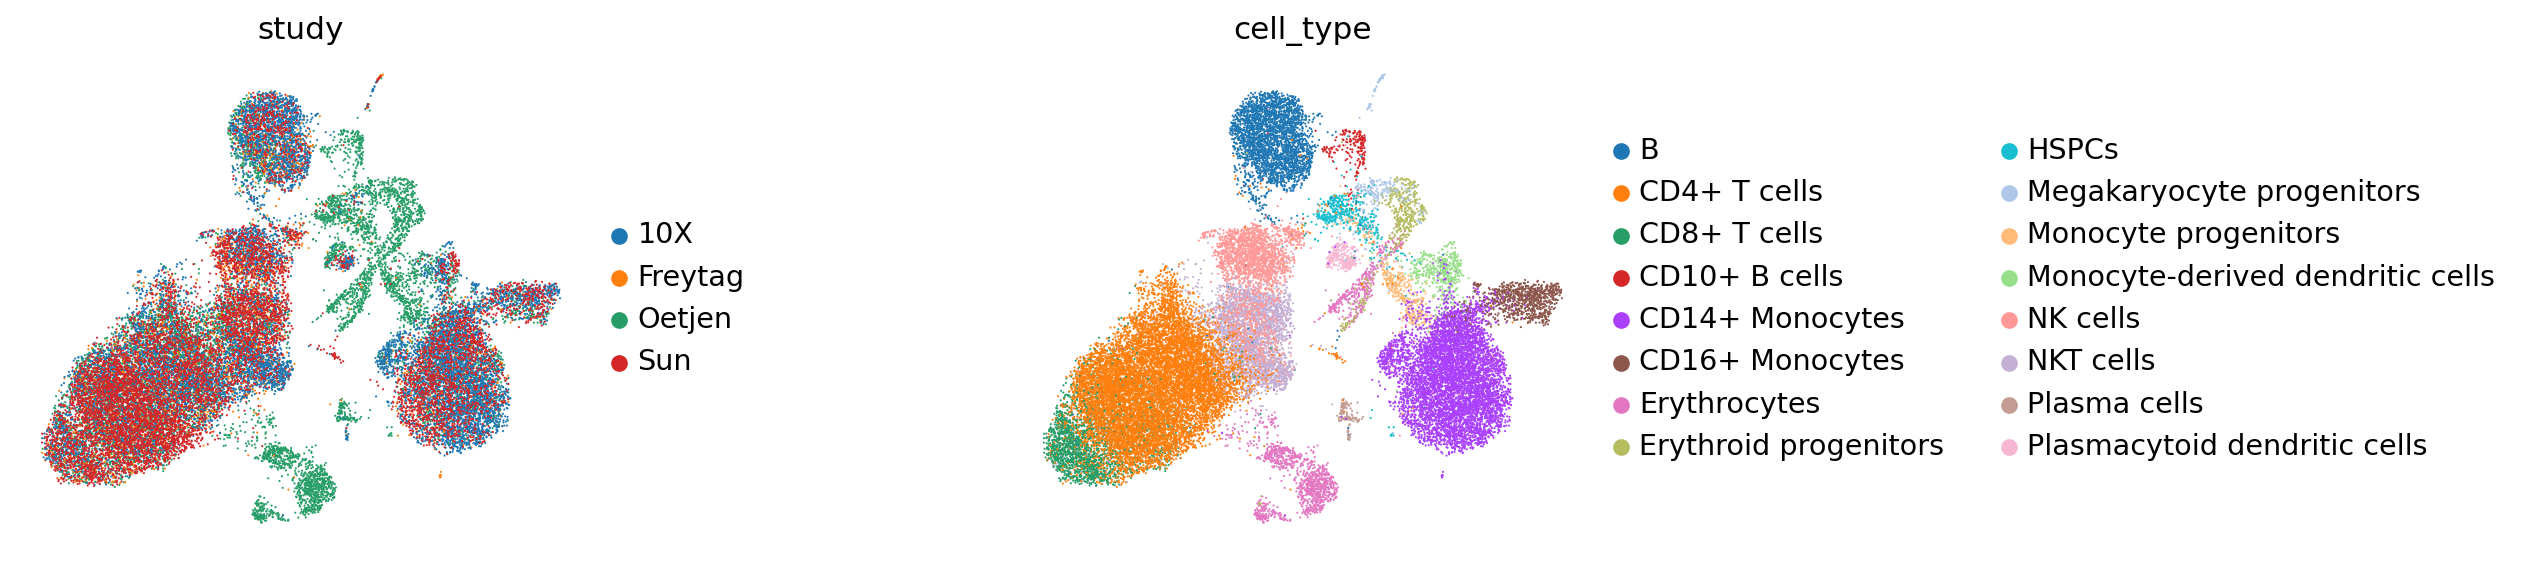

In [34]:
sc.pp.neighbors(adata_latent, n_neighbors=8)
sc.tl.leiden(adata_latent)
sc.tl.umap(adata_latent)
sc.pl.umap(adata_latent,
           color=[condition_key, 'cell_type'],
           frameon=False,
           wspace=0.6,
           )

After pretraining the model can be saved for later use

In [35]:
ref_path = 'reference_model/'
trvae.save(ref_path, overwrite=True)

In [36]:
target_adata = target_adata[:, source_adata.var_names]
target_adata

View of AnnData object with n_obs × n_vars = 13576 × 1972
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'stim', 'seurat_annotations', 'integrated_snn_res.0.5', 'seurat_clusters', 'condition', 'cell_type', 'study', 'ref_or_query'
    uns: 'terms'

### Perform surgery on reference model and train on query dataset using one-shot mapping

In [37]:
time_one_array = []

for epochs in reversed(range(1,11)):
    start_time_1 = timeit.default_timer()

    query_model_one_1 = trvae.one_shot_surgery(target_adata, ref_path, copy=False, pretrain = epochs)

    time_one = timeit.default_timer() - start_time_1
    print(f'Executed in {time_one} seconds') 
    
    if epochs == 10:
        query_model_one = query_model_one_1
        val_loss_1 = query_model_one.trainer.logs['val_loss']
    time_one_array.append(time_one)

AnnData object with n_obs × n_vars = 13576 × 1972
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'stim', 'seurat_annotations', 'integrated_snn_res.0.5', 'seurat_clusters', 'condition', 'cell_type', 'study', 'ref_or_query', '_original_study'
    uns: 'terms'

INITIALIZING NEW NETWORK..............
Encoder Architecture:
	Input Layer in, out and cond: 1972 128 4
	Hidden Layer 1 in/out: 128 128
	Mean/Var Layer in/out: 128 10
Decoder Architecture:
	First Layer in, out and cond:  10 128 4
	Hidden Layer 1 in/out: 128 128
	Output Layer in/out:  128 1972 

Device cpu
Processing original category: Kang n_obs: 13576
  processing Oetjen
  processing Freytag
  processing 10X
  processing Sun

INITIALIZING NEW NETWORK..............
Encoder Architecture:
	Input Layer in, out and cond: 1972 128 5
	Hidden Layer 1 in/out: 128 128
	Mean/Var Layer in/out: 128 10
Decoder Architecture:
	First Layer in, out and cond:  10 128 5
	Hidden Layer 1 in/out: 128 128
	Output Layer in/out:  128 1972 

 |████████

### Perform surgery on reference model and train on query dataset using zero-shot mapping

In [38]:
start_time_0 = timeit.default_timer()

query_model_zero = trvae.one_shot_surgery(target_adata, ref_path, copy=False, pretrain = 0)

time_zero = timeit.default_timer() - start_time_0
print(f'Executed in {time_zero} seconds')

AnnData object with n_obs × n_vars = 13576 × 1972
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'stim', 'seurat_annotations', 'integrated_snn_res.0.5', 'seurat_clusters', 'condition', 'cell_type', 'study', 'ref_or_query', '_original_study'
    uns: 'terms'

INITIALIZING NEW NETWORK..............
Encoder Architecture:
	Input Layer in, out and cond: 1972 128 4
	Hidden Layer 1 in/out: 128 128
	Mean/Var Layer in/out: 128 10
Decoder Architecture:
	First Layer in, out and cond:  10 128 4
	Hidden Layer 1 in/out: 128 128
	Output Layer in/out:  128 1972 

Device cpu
Processing original category: Kang n_obs: 13576
  processing Oetjen
  processing Freytag
  processing 10X
  processing Sun

INITIALIZING NEW NETWORK..............
Encoder Architecture:
	Input Layer in, out and cond: 1972 128 5
	Hidden Layer 1 in/out: 128 128
	Mean/Var Layer in/out: 128 10
Decoder Architecture:
	First Layer in, out and cond:  10 128 5
	Hidden Layer 1 in/out: 128 128
	Output Layer in/out:  128 1972 

Executed i

### Perform surgery on reference model and train on query dataset using full query training

In [39]:
query_model_full = sca.models.TRVAE.load_query_data(adata=target_adata, reference_model=ref_path)

AnnData object with n_obs × n_vars = 13576 × 1972
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'stim', 'seurat_annotations', 'integrated_snn_res.0.5', 'seurat_clusters', 'condition', 'cell_type', 'study', 'ref_or_query', '_original_study'
    uns: 'terms'

INITIALIZING NEW NETWORK..............
Encoder Architecture:
	Input Layer in, out and cond: 1972 128 5
	Hidden Layer 1 in/out: 128 128
	Mean/Var Layer in/out: 128 10
Decoder Architecture:
	First Layer in, out and cond:  10 128 5
	Hidden Layer 1 in/out: 128 128
	Output Layer in/out:  128 1972 



In [40]:
start_time_f = timeit.default_timer()

query_model_full.train(
    n_epochs=surgery_epochs,
    alpha_epoch_anneal=alpha_epoch,
    early_stopping_kwargs=early_stopping_kwargs,
    weight_decay=0
)

time_full = timeit.default_timer() - start_time_f
print(f'Executed in {time_full} seconds') 

 |███████-------------| 35.6%  - val_loss: 579.5510475852 - val_recon_loss: 569.3273925781 - val_kl_loss: 11.5521456112 - val_mmd_loss: 0.0000000000
ADJUSTED LR
 |███████-------------| 39.4%  - val_loss: 578.4531471946 - val_recon_loss: 567.2825872248 - val_kl_loss: 11.3985293128 - val_mmd_loss: 0.0000000000
ADJUSTED LR
 |████████------------| 42.4%  - val_loss: 579.9822443182 - val_recon_loss: 568.5714444247 - val_kl_loss: 11.4108092568 - val_mmd_loss: 0.0000000000
ADJUSTED LR
 |████████------------| 43.8%  - val_loss: 577.9908613725 - val_recon_loss: 566.6311867454 - val_kl_loss: 11.3596666509 - val_mmd_loss: 0.0000000000
Stopping early: no improvement of more than 0 nats in 20 epochs
If the early stopping criterion is too strong, please instantiate it with different parameters in the train method.
Saving best state of network...
Best State was in Epoch 218
Executed in 156.91731947474182 seconds


#### Time Benchmarking results

In [41]:
time_zero

6.693355360999703

In [42]:
time_one_array

[22.355829721316695,
 13.29843077622354,
 12.248750204220414,
 11.865288704633713,
 10.678305147215724,
 10.120092226192355,
 9.936964474618435,
 9.309545831754804,
 8.530967751517892,
 7.837623313069344]

In [43]:
time_full

156.91731947474182

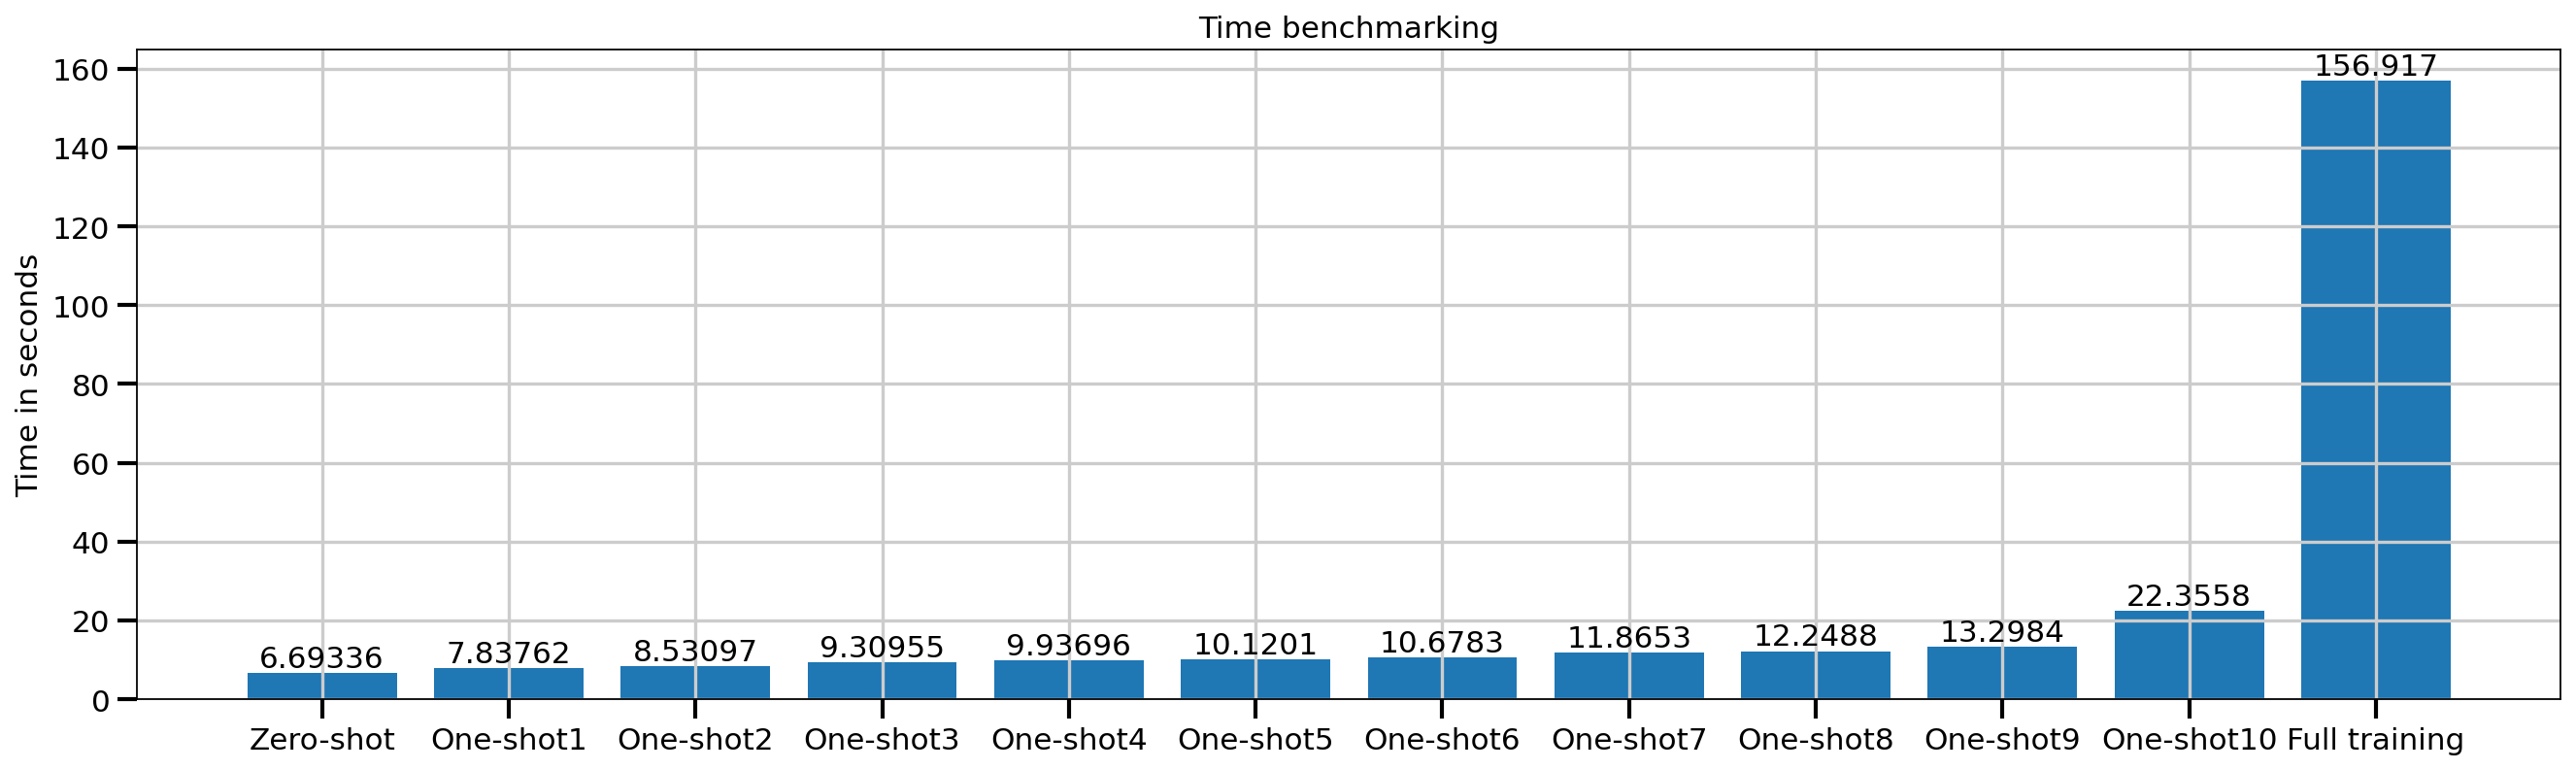

In [44]:
from matplotlib import pyplot as plt

time = time_one_array.copy()
time.reverse()
time.append(time_full)
time.insert(0, time_zero)

x = [f'One-shot{i}' for i in range(1,11)]
x.append('Full training')
x.insert(0, 'Zero-shot')

plt.rcParams["figure.figsize"] = (20,5.5)
bars = plt.bar(x, time)
plt.bar_label(bars)
plt.title('Time benchmarking')
plt.ylabel('Time in seconds')
plt.show()

#### Value loss comparison

In [45]:
val_loss_1 = query_model_one.trainer.logs["val_loss"]
val_loss_full = query_model_full.trainer.logs["val_loss"]

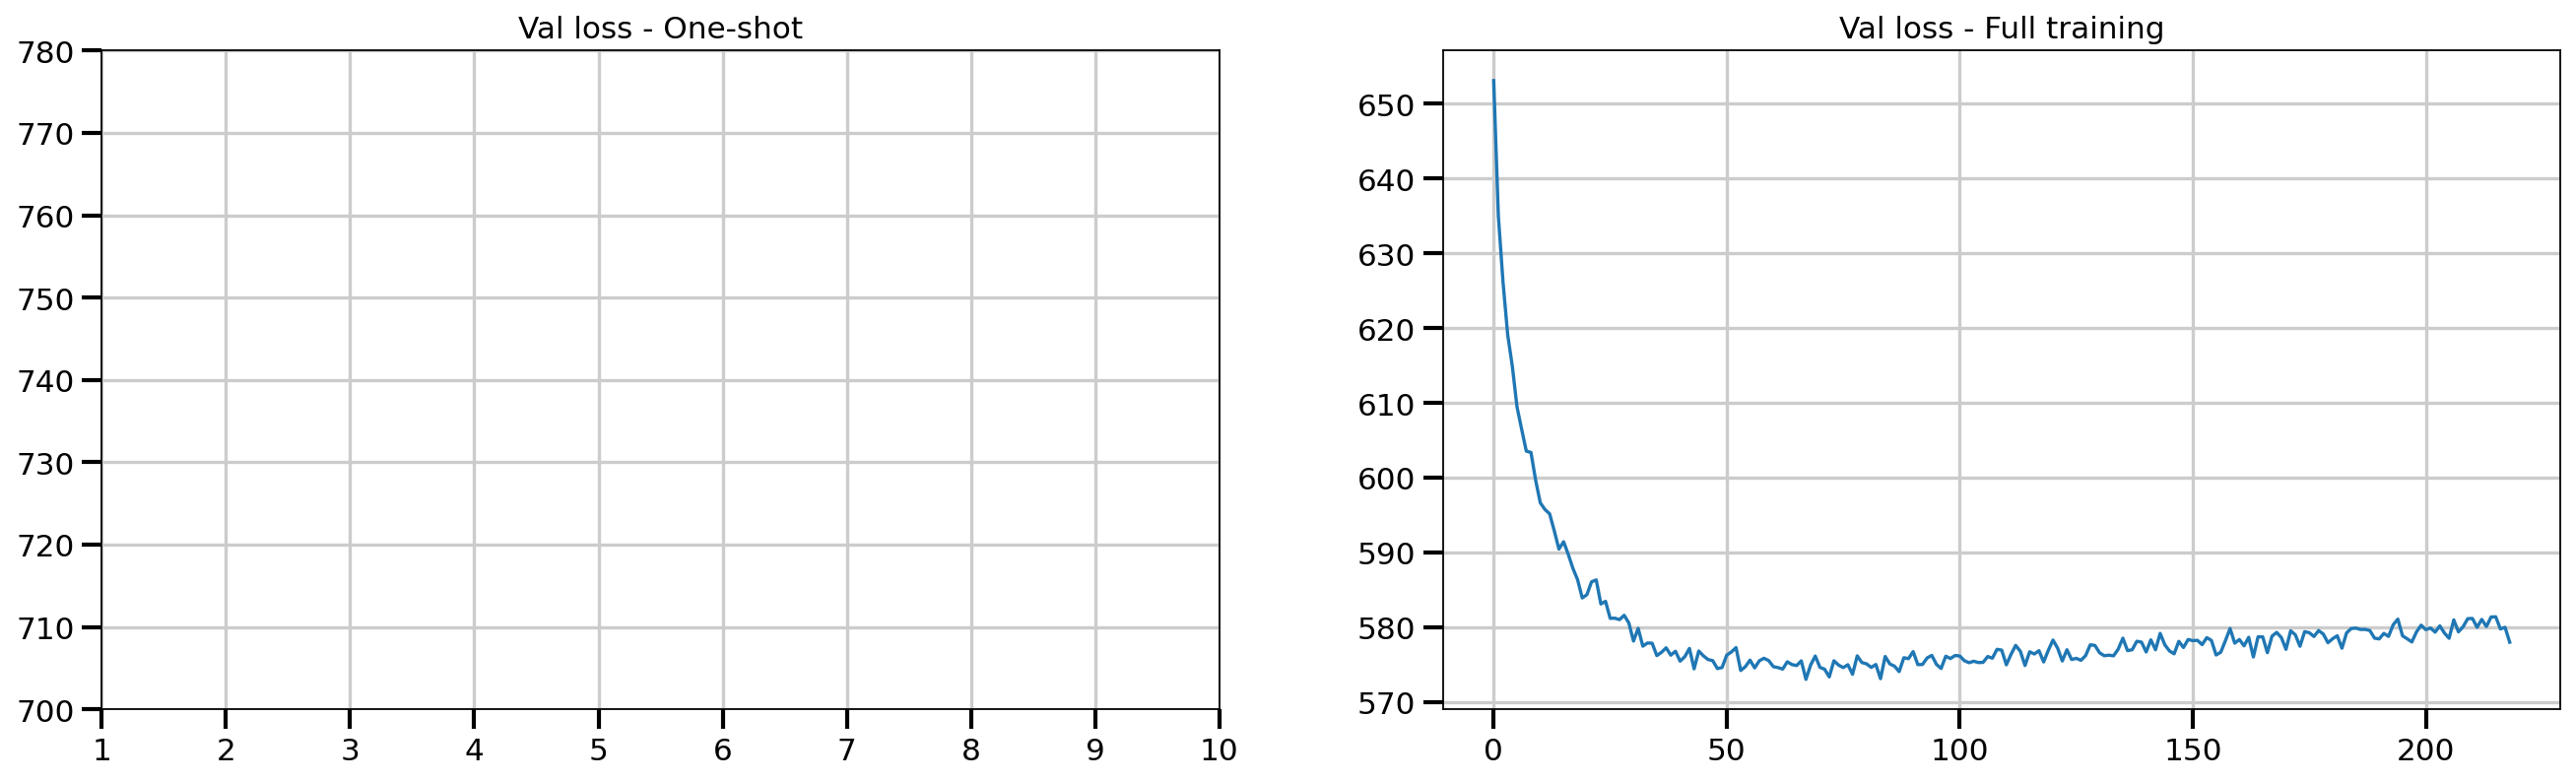

In [46]:

plt.subplot(1, 2, 1)
plt.plot(range(1,11), val_loss_1, label='Val loss')
plt.axis([1, 10, 700, 780])
plt.title('Val loss - One-shot')

plt.subplot(1, 2, 2)
plt.plot(range(len(val_loss_full)), val_loss_full, label='Val Loss')
plt.title('Val loss - Full training')
plt.show()

#### Latent Representations

In [47]:
surg_path = ['query_model_zero', 'query_model_one', 'query_model_full']

In [48]:
adata_latent_array = []
models = [query_model_zero, query_model_one, query_model_full]

In [49]:
for model in models:
    adata_latent = sc.AnnData(model.get_latent())
    adata_latent.obs['cell_type'] = target_adata.obs[cell_type_key].tolist()
    adata_latent.obs[condition_key] = target_adata.obs[condition_key].tolist()
    adata_latent_array.append(adata_latent)

In [50]:
adata_latent_array

[AnnData object with n_obs × n_vars = 13576 × 10
     obs: 'cell_type', 'study',
 AnnData object with n_obs × n_vars = 13576 × 10
     obs: 'cell_type', 'study',
 AnnData object with n_obs × n_vars = 13576 × 10
     obs: 'cell_type', 'study']

In [51]:
sc.settings.set_figure_params(dpi=200, frameon=False)
sc.set_figure_params(dpi=200)
sc.set_figure_params(figsize=(4, 4))
torch.set_printoptions(precision=3, sci_mode=False, edgeitems=7)

/home/icb/aleksandra.topalova/miniconda3/lib/python3.9/site-packages/scanpy/_settings.py:447: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  IPython.display.set_matplotlib_formats(*ipython_format)


/home/icb/aleksandra.topalova/miniconda3/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:163: PendingDeprecationWarning: The get_cmap function will be deprecated in a future version. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = copy(get_cmap(cmap))


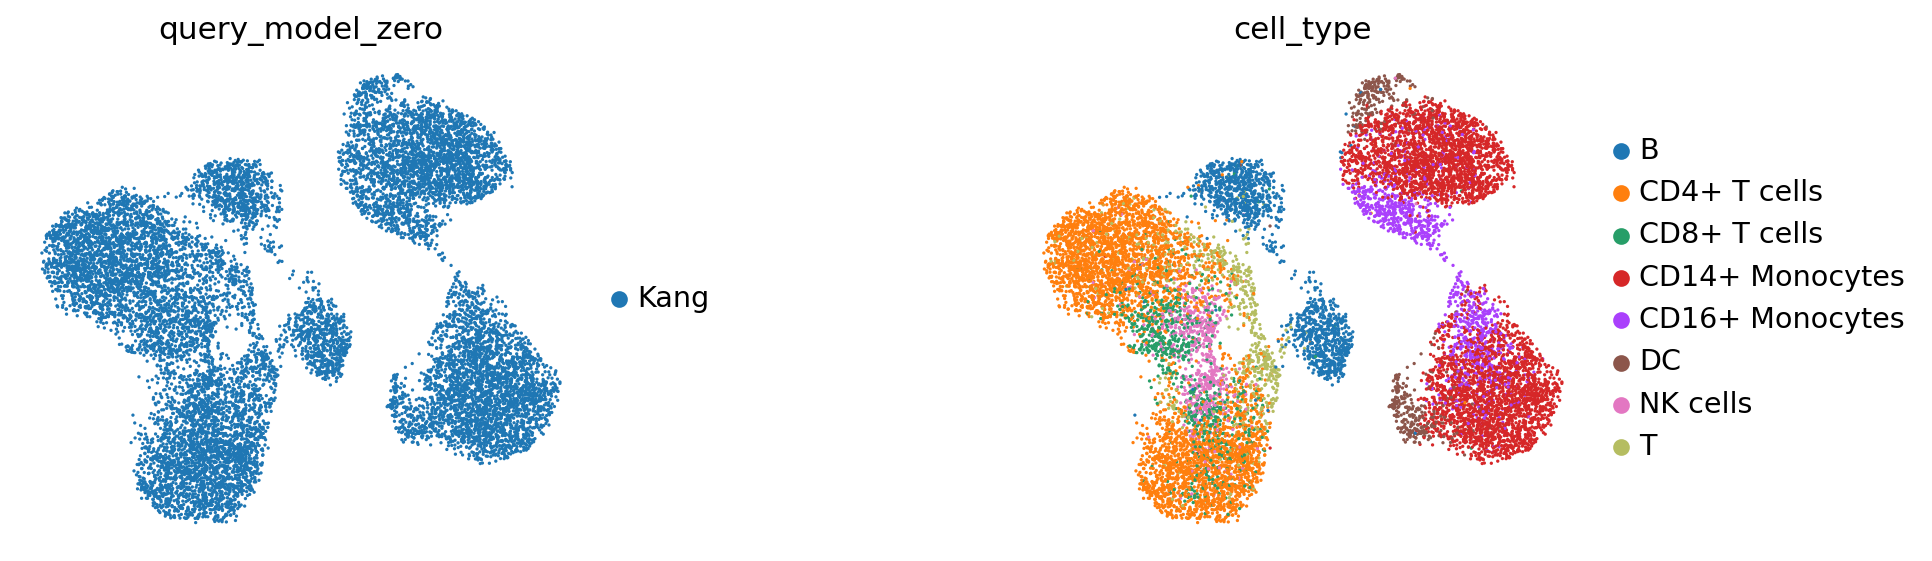

/home/icb/aleksandra.topalova/miniconda3/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:163: PendingDeprecationWarning: The get_cmap function will be deprecated in a future version. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = copy(get_cmap(cmap))


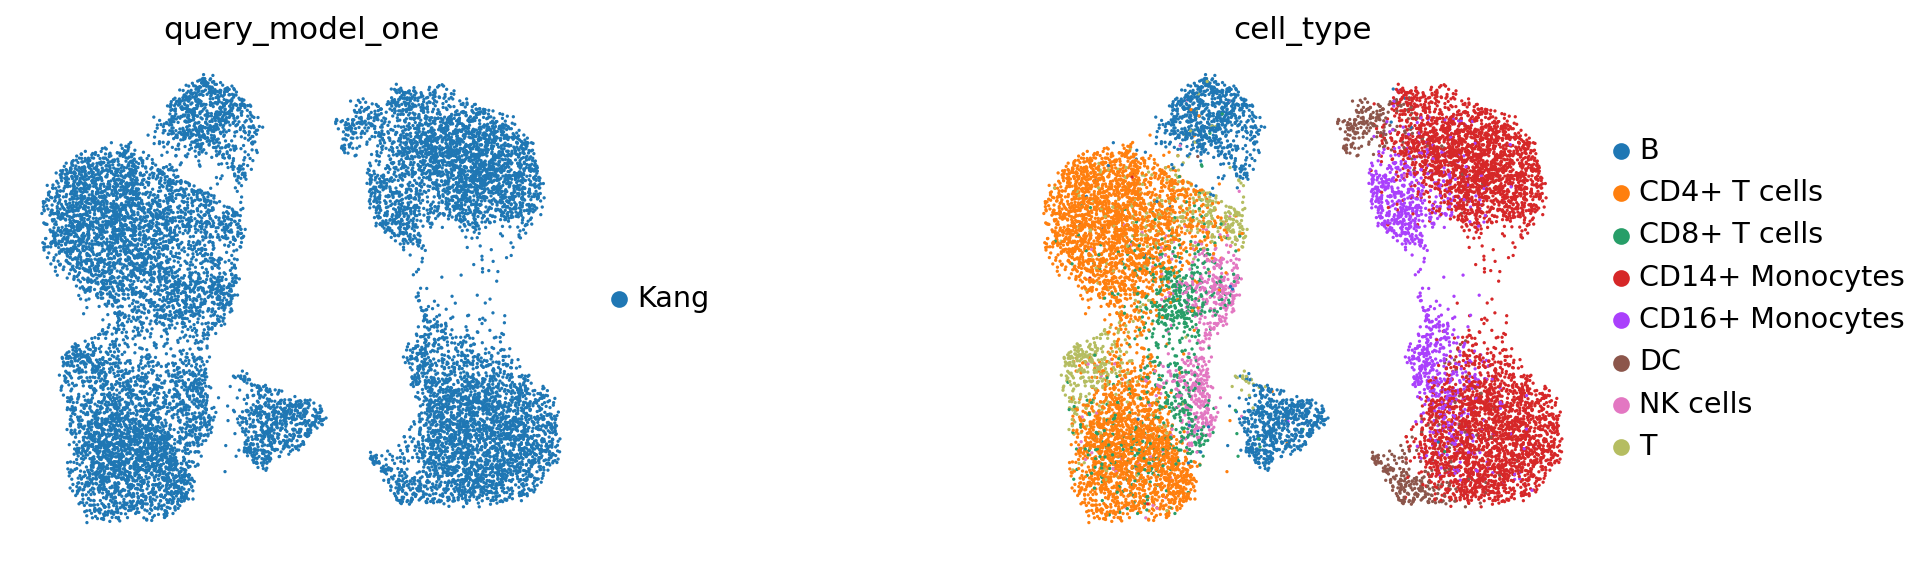

/home/icb/aleksandra.topalova/miniconda3/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:163: PendingDeprecationWarning: The get_cmap function will be deprecated in a future version. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = copy(get_cmap(cmap))


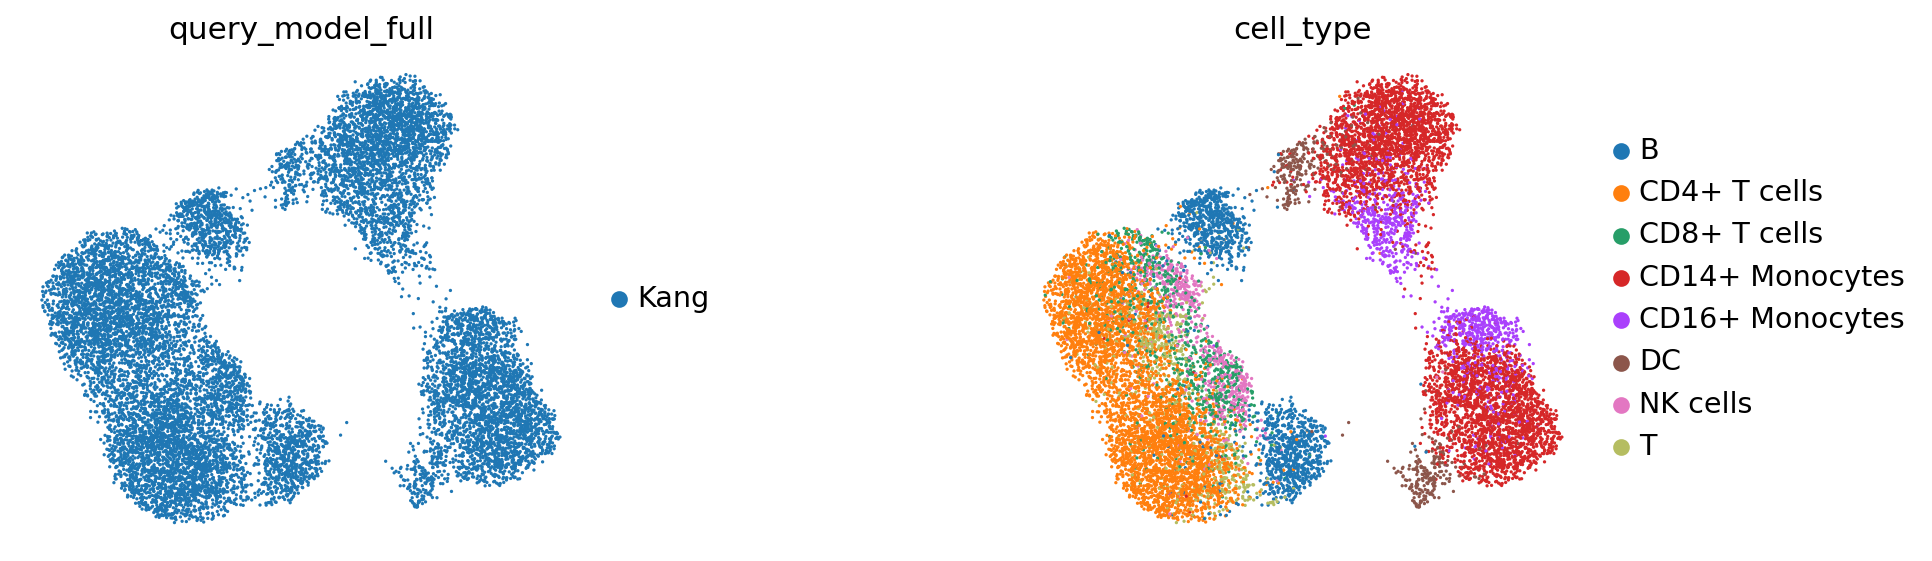

In [52]:
for i in range(len(adata_latent_array)):
    sc.pp.neighbors(adata_latent_array[i], n_neighbors=8)
    sc.tl.leiden(adata_latent_array[i])
    sc.tl.umap(adata_latent_array[i])
    sc.pl.umap(adata_latent_array[i],
           color=[condition_key, cell_type_key],
           frameon=False,
           wspace=0.6,
           title = surg_path[i]
           )

In [53]:
for j in range(len(models)):
    models[j].save(surg_path[j], overwrite=True)

### Get latent representation of reference + query dataset and compute UMAP

In [54]:
adata = adata[:, source_adata.var_names]
adata

View of AnnData object with n_obs × n_vars = 46060 × 1972
    obs: 'batch', 'chemistry', 'data_type', 'dpt_pseudotime', 'final_annotation', 'mt_frac', 'n_counts', 'n_genes', 'sample_ID', 'size_factors', 'species', 'study', 'tissue', 'cell_type', 'ref_or_query', 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'stim', 'seurat_annotations', 'integrated_snn_res.0.5', 'seurat_clusters', 'condition'
    var: 'highly_variable-0', 'means-0', 'dispersions-0', 'dispersions_norm-0', 'highly_variable_nbatches-0', 'highly_variable_intersection-0'
    uns: 'terms'

In [55]:
full_latent_array = []

In [56]:
adata.obs['ref_or_query'] = np.where(adata.obs[condition_key].isin(target_conditions), 'query', 'ref')

In [57]:
for model in models:
    full_latent = sc.AnnData(model.get_latent(adata.X, adata.obs[condition_key]))
    full_latent.obs['cell_type'] = adata.obs[cell_type_key].tolist()
    full_latent.obs[condition_key] = adata.obs[condition_key].tolist()
    full_latent.obs['ref_or_query'] = adata.obs['ref_or_query'].tolist()
    full_latent_array.append(full_latent)

/home/icb/aleksandra.topalova/miniconda3/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:163: PendingDeprecationWarning: The get_cmap function will be deprecated in a future version. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = copy(get_cmap(cmap))


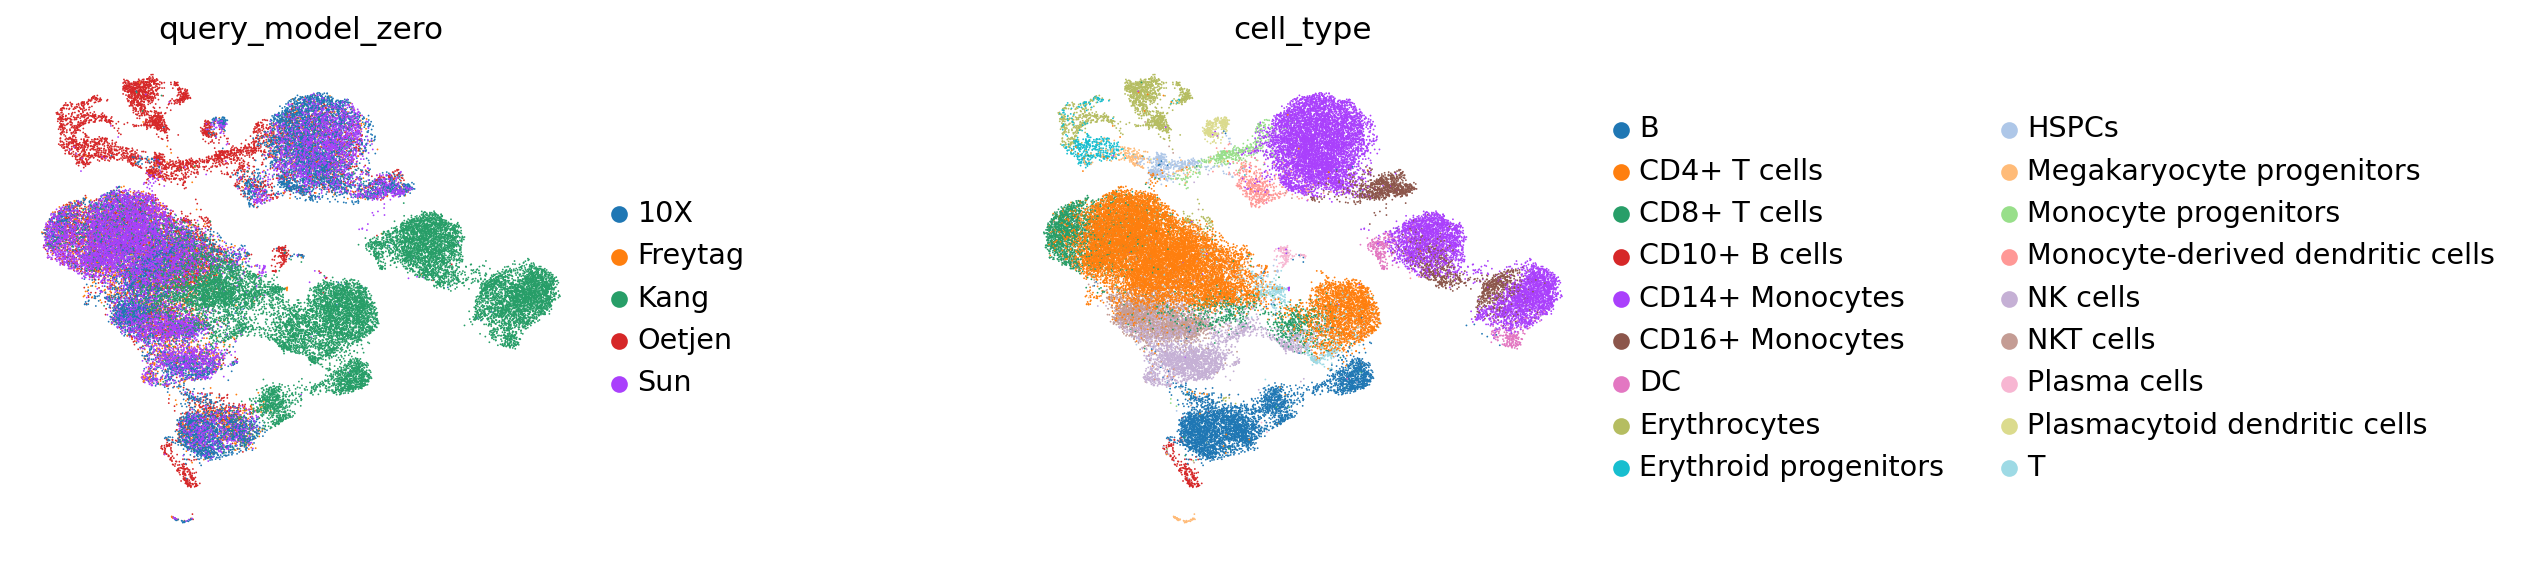

/home/icb/aleksandra.topalova/miniconda3/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:163: PendingDeprecationWarning: The get_cmap function will be deprecated in a future version. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = copy(get_cmap(cmap))


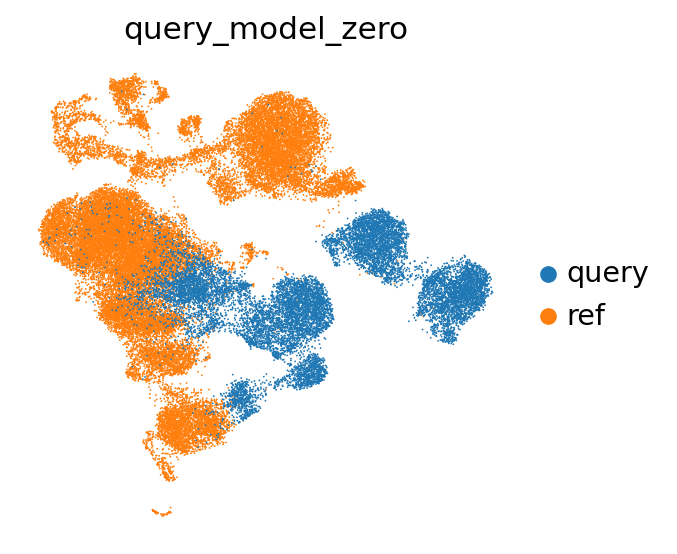

/home/icb/aleksandra.topalova/miniconda3/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:163: PendingDeprecationWarning: The get_cmap function will be deprecated in a future version. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = copy(get_cmap(cmap))


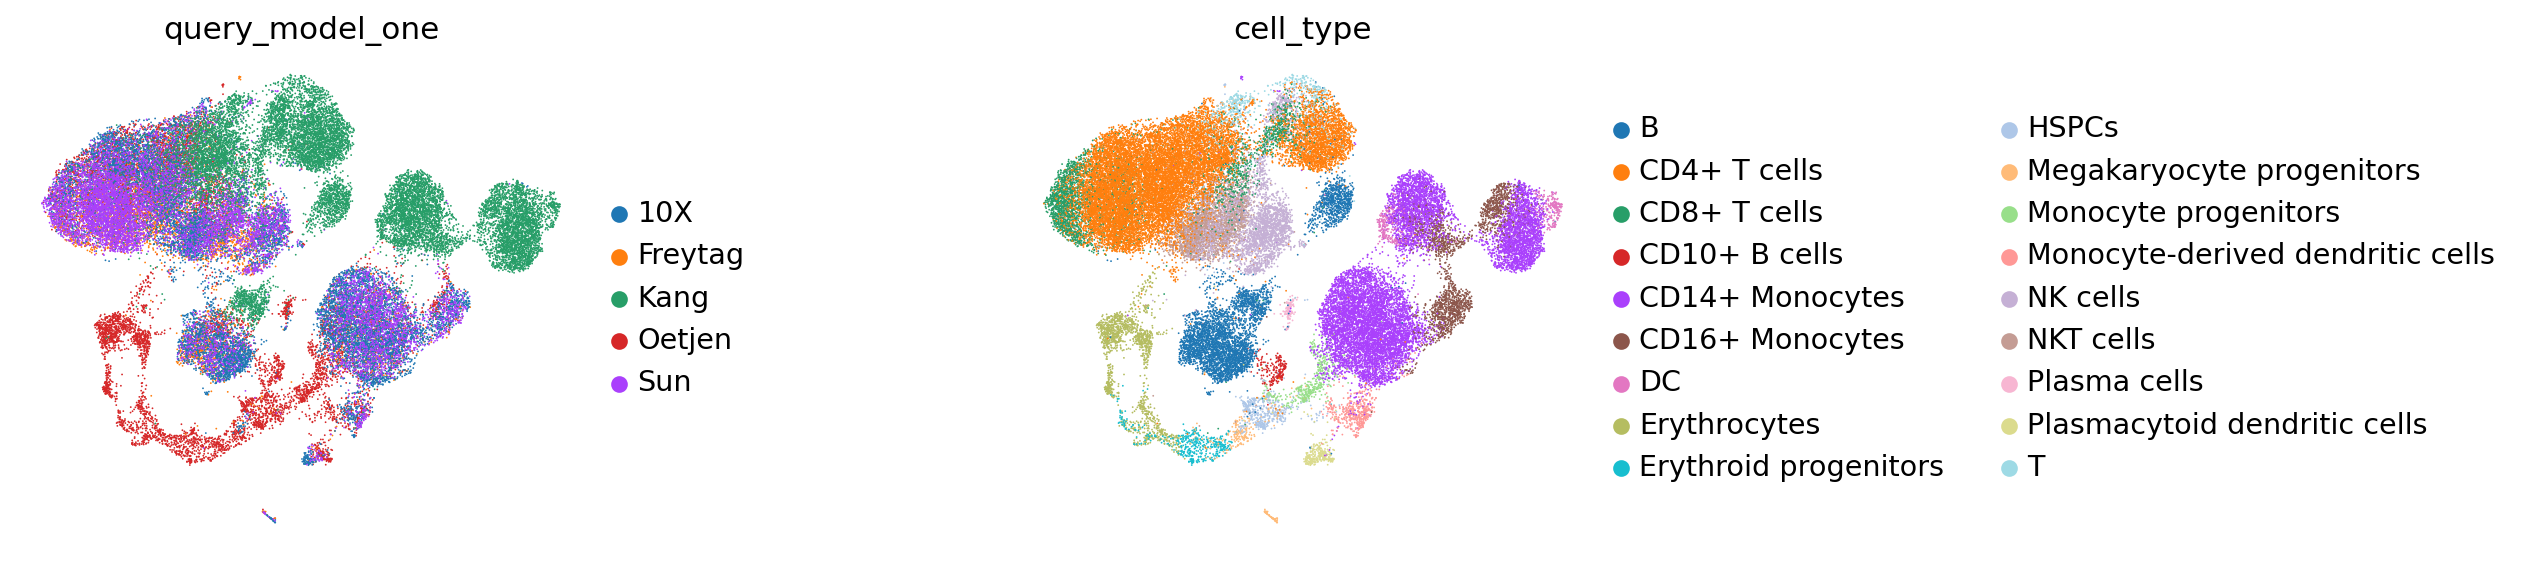

/home/icb/aleksandra.topalova/miniconda3/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:163: PendingDeprecationWarning: The get_cmap function will be deprecated in a future version. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = copy(get_cmap(cmap))


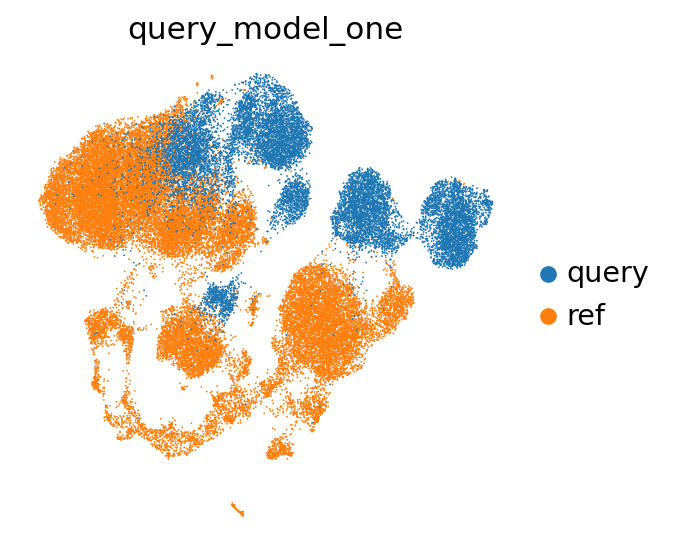

/home/icb/aleksandra.topalova/miniconda3/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:163: PendingDeprecationWarning: The get_cmap function will be deprecated in a future version. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = copy(get_cmap(cmap))


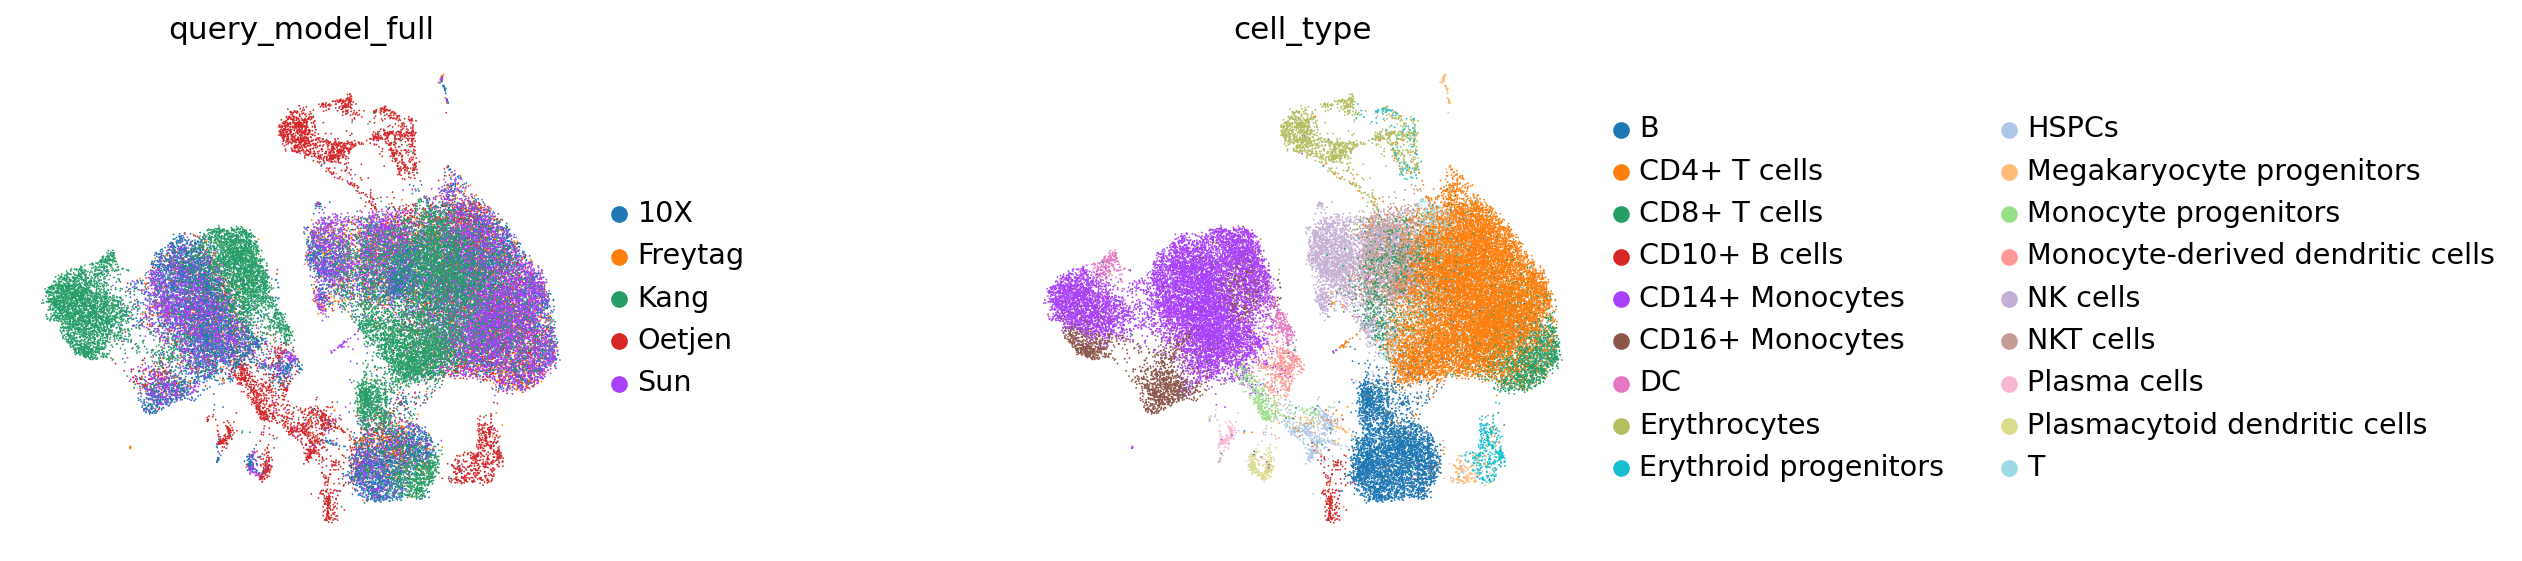

/home/icb/aleksandra.topalova/miniconda3/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:163: PendingDeprecationWarning: The get_cmap function will be deprecated in a future version. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = copy(get_cmap(cmap))


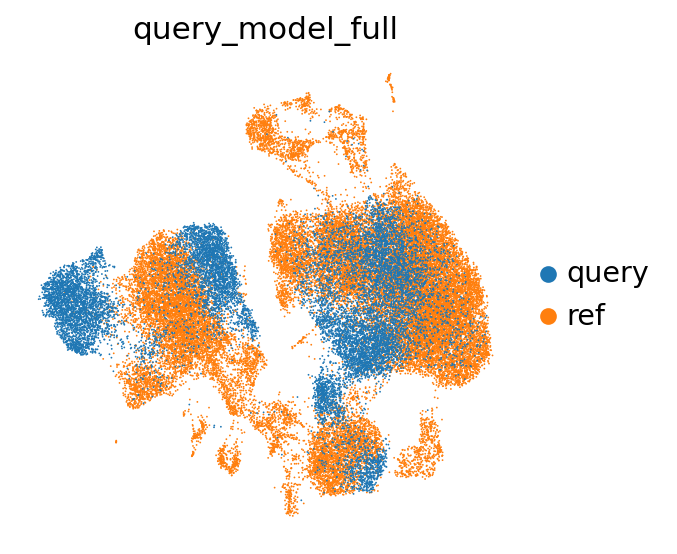

In [58]:
for i in range(len(full_latent_array)):
    sc.pp.neighbors(full_latent_array[i], n_neighbors=8)
    sc.tl.leiden(full_latent_array[i])
    sc.tl.umap(full_latent_array[i])
    sc.pl.umap(full_latent_array[i],
           color=[condition_key, 'cell_type'],
           frameon=False,
           wspace=0.6,
           title = surg_path[i]
           )
    sc.pl.umap(full_latent_array[i],
           color=['ref_or_query'],
           frameon=False,
           wspace=0.6,
           title = surg_path[i]
           )

## Benchmarking for Biological Conservation and Batch Correction

In [59]:
results_array = []

In [60]:
full_latent_array

[AnnData object with n_obs × n_vars = 46060 × 10
     obs: 'cell_type', 'study', 'ref_or_query', 'leiden'
     uns: 'neighbors', 'leiden', 'umap', 'study_colors', 'cell_type_colors', 'ref_or_query_colors'
     obsm: 'X_umap'
     obsp: 'distances', 'connectivities',
 AnnData object with n_obs × n_vars = 46060 × 10
     obs: 'cell_type', 'study', 'ref_or_query', 'leiden'
     uns: 'neighbors', 'leiden', 'umap', 'study_colors', 'cell_type_colors', 'ref_or_query_colors'
     obsm: 'X_umap'
     obsp: 'distances', 'connectivities',
 AnnData object with n_obs × n_vars = 46060 × 10
     obs: 'cell_type', 'study', 'ref_or_query', 'leiden'
     uns: 'neighbors', 'leiden', 'umap', 'study_colors', 'cell_type_colors', 'ref_or_query_colors'
     obsm: 'X_umap'
     obsp: 'distances', 'connectivities']

In [61]:
adata.obs['cell_type'] = adata.obs['final_annotation']

In [62]:
for i in range(len(full_latent_array)):
    results = scib.metrics.metrics(
        adata, full_latent_array[i],
        batch_key= condition_key,label_key = 'cell_type', organism= 'human', subsample=1., embed = 'X_umap',
        graph_conn_=True, nmi_ = True, ari_ = True,
        ilisi_=False, isolated_labels_asw_= True, cell_cycle_= True,
        silhouette_=True
    )
    results_array.append(results)

NMI...
ARI...
Silhouette score...
cell cycle effect...
Isolated labels ASW...
Graph connectivity...
NMI...
ARI...
Silhouette score...
cell cycle effect...
Isolated labels ASW...
Graph connectivity...
NMI...
ARI...
Silhouette score...
cell cycle effect...
Isolated labels ASW...
Graph connectivity...


In [63]:
def median_bio_conserv(results):
    column = results[0]
    return (column.iloc[0] + column.iloc[1] + column.iloc[2] + column.iloc[4])/4

In [64]:
def median_batch_corr(results):
    column = results[0]
    return (column.iloc[3] + column.iloc[5] + column.iloc[6])/3

# Results

In [65]:
results_zero = results_array[0].dropna()


In [66]:
print('Zero shot: ')
print(f"bio_conservation = {median_bio_conserv(results=results_zero)}")
print(f"batch_correction = {median_batch_corr(results=results_zero)}")
results_zero

Zero shot: 
bio_conservation = 0.5631656146072261
batch_correction = 0.7056076881435748


0
NMI_cluster/label          0.645884
ARI_cluster/label          0.534365
ASW_label                  0.440341
ASW_label/batch            0.649337
cell_cycle_conservation    0.632073
isolated_label_silhouette  0.539487
graph_conn                 0.927999

In [67]:
results_one = results_array[1].dropna()

In [68]:
print('One shot: ')
print(f"batch_correction = {median_bio_conserv(results=results_one)}")
print(f"batch_correction = {median_batch_corr(results=results_one)}")
results_one

One shot: 
batch_correction = 0.5360416894490339
batch_correction = 0.733429597889485


0
NMI_cluster/label          0.644980
ARI_cluster/label          0.431618
ASW_label                  0.466081
ASW_label/batch            0.719934
cell_cycle_conservation    0.601487
isolated_label_silhouette  0.533545
graph_conn                 0.946809

In [69]:
results_full = results_array[2].dropna()

In [70]:
print('Full query: ')
print(f"bio_conservation = {median_bio_conserv(results=results_full)}")
print(f"batch_correction = {median_batch_corr(results=results_full)}")
results_full

Full query: 
bio_conservation = 0.6131871866056339
batch_correction = 0.7181948961787427


0
NMI_cluster/label          0.651294
ARI_cluster/label          0.583383
ASW_label                  0.544493
ASW_label/batch            0.731364
cell_cycle_conservation    0.673578
isolated_label_silhouette  0.517460
graph_conn                 0.905760